In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/survey-of-consumer-finances-data/SCFP2019.csv
/kaggle/input/data-dictionary-for-customer-segmentation-usa/hcbk.htm


In this project assignment, you're going to focus on business owners in the United States. You'll start by examining some demographic characteristics of the group, such as age, income category, and debt vs home value. Then you'll select high-variance features, and create a clustering model to divide small business owners into subgroups. Finally, you'll create some visualizations to highlight the differences between these subgroups. Good luck! 

`1. Prepare Data

`a. Import`

Task 6.5.1: Read the file "data/SCFP2019.csv.gz" into the DataFrame df.

In [2]:
# Read compressed CSV file into DataFrame
df = pd.read_csv("/kaggle/input/survey-of-consumer-finances-data/SCFP2019.csv")

# Print shape of the DataFrame
print("df shape:", df.shape)

# Display first few rows of DataFrame
df.head()

df shape: (28885, 356)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,6119.779308,2,75,6,12,4,2,0,...,5,3,6,3,2,10,6,6,3,3
1,1,12,4712.374912,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
2,1,13,5145.224455,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
3,1,14,5297.663412,2,75,6,12,4,2,0,...,5,2,6,2,1,10,4,4,2,2
4,1,15,4761.812371,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2


`b. Explore`

As mentioned at the start of this assignment, you're focusing on business owners. But what percentage of the respondents in df are business owners?

Task 6.5.2: Calculate the proportion of respondents in df that are business owners, and assign the result to the variable prop_biz_owners. You'll need to review the documentation regarding the "HBUS" column to complete these tasks.

In [3]:
# Count occurrences of 'HBUS'
df["HBUS"].value_counts(normalize=True)


HBUS
0    0.725982
1    0.274018
Name: proportion, dtype: float64

In [4]:
# Extracting value counts of a specific column
prop_biz_owners = df["HBUS"].value_counts(normalize=True)[1]

# Printing proportion of business owners
print("proportion of business owners in df:", prop_biz_owners)


proportion of business owners in df: 0.2740176562229531


Is the distribution of income different for business owners and non-business owners?

Task 6.5.3: Create a DataFrame df_inccat that shows the normalized frequency for income categories for business owners and non-business owners.

In [5]:
# Define income category dictionary
inccat_dict = {
    1: "0-20",
    2: "21-39.9",
    3: "40-59.9",
    4: "60-79.9",
    5: "80-89.9",
    6: "90-100",
}

# Replace values in "INCCAT" column with corresponding ranges
# Group by "HBUS" and calculate value counts normalized by total
df_inccat = (
    df["INCCAT"]
    .replace(inccat_dict)
    .groupby(df["HBUS"])
    .value_counts(normalize=True)
    .rename("frequency")
    .to_frame()
    .reset_index()
)

# Display the resulting DataFrame
df_inccat


,HBUS,INCCAT,frequency
0,0,0-20,0.210348
1,0,21-39.9,0.198140
2,0,40-59.9,0.189080
3,0,60-79.9,0.186600
4,0,90-100,0.117167
5,0,80-89.9,0.098665
6,1,90-100,0.629438
7,1,60-79.9,0.119015
8,1,80-89.9,0.097410
9,1,40-59.9,0.071510


Task 6.5.4: Using seaborn, create a side-by-side bar chart of df_inccat. Set hue to "HBUS", and make sure that the income categories are in the correct order along the x-axis. Label to the x-axis "Income Category", the y-axis "Frequency (%)", and use the title "Income Distribution: Business Owners vs. Non-Business Owners".

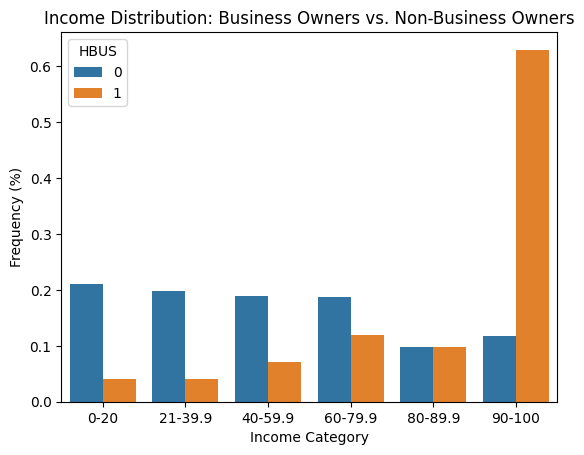

In [6]:
# Create bar chart of `df_inccat`
sns.barplot(
    x="INCCAT",
    y="frequency",
    hue="HBUS",
    data=df_inccat,
    order = inccat_dict.values()
)
# Customize the chart
plt.xlabel("Income Category")
plt.ylabel("Frequency (%)")
plt.title("Income Distribution: Business Owners vs. Non-Business Owners");

We looked at the relationship between home value and household debt in the context of the the credit fearful, but what about business owners? Are there notable differences between business owners and non-business owners?

Task 6.5.5: Using seaborn, create a scatter plot that shows "HOUSES" vs. "DEBT". You should color the datapoints according to business ownership. Be sure to label the x-axis "Household Debt", the y-axis "Home Value", and use the title "Home Value vs. Household Debt".

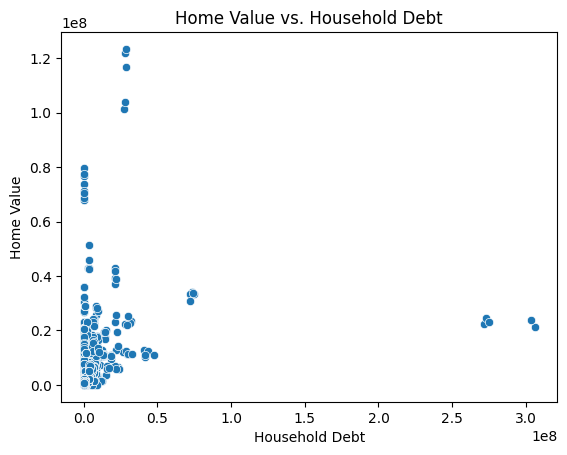

In [7]:
# Plot "HOUSES" vs "DEBT" with hue as business ownership
sns.scatterplot(
    x="DEBT",
    y="HOUSES",
    data=df
)
plt.xlabel("Household Debt")
plt.ylabel("Home Value")
plt.title("Home Value vs. Household Debt");


For the model building part of the assignment, you're going to focus on small business owners, defined as respondents who have a business and whose income does not exceed $500,000.

Task 6.5.6: Create a new DataFrame df_small_biz that contains only business owners whose income is below $500,000.

In [8]:
# Create mask for small business condition
mask = (df["HBUS"] == 1) & (df["INCOME"] < 5e5)
# Filter dataframe using the mask
df_small_biz = df[mask]
# Print shape of filtered dataframe
print("df_small_biz shape:", df_small_biz.shape)
# Display first few rows of filtered dataframe
df_small_biz.head()


df_small_biz shape: (4161, 356)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
80,17,171,7802.265717,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
81,17,172,8247.536301,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
82,17,173,8169.562719,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
83,17,174,8087.704517,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4
84,17,175,8276.510048,1,62,4,12,4,1,0,...,3,5,5,5,2,7,9,9,4,4


We saw that credit-fearful respondents were relatively young. Is the same true for small business owners?

Task 6.5.7: Create a histogram from the "AGE" column in df_small_biz with 10 bins. Be sure to label the x-axis "Age", the y-axis "Frequency (count)", and use the title "Small Business Owners: Age Distribution".

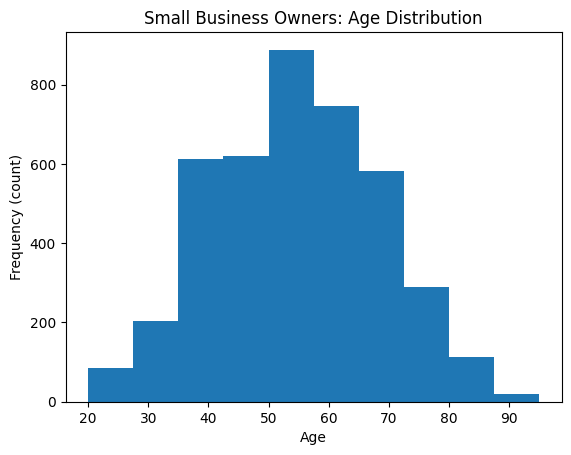

In [9]:
# Plot histogram of "AGE"
# Create a histogram from the "AGE" column with 10 bins
plt.hist(df_small_biz["AGE"], bins=10)

# Add labels and title
plt.xlabel("Age")
plt.ylabel("Frequency (count)")
plt.title("Small Business Owners: Age Distribution");

Let's take a look at the variance in the dataset.

Task 6.5.8: Calculate the variance for all the features in df_small_biz, and create a Series top_ten_var with the 10 features with the largest variance.

In [10]:
df_small_biz_var = df_small_biz.var()
# Calculate variance, get 10 largest features
top_ten_var = df_small_biz_var.sort_values(ascending=False).head(10)
top_ten_var

ASSET       1.951155e+14
NETWORTH    1.818870e+14
NHNFIN      1.196403e+14
NFIN        1.149004e+14
KGTOTAL     7.454386e+13
BUS         6.670909e+13
ACTBUS      6.432674e+13
KGBUS       6.053296e+13
FIN         2.738802e+13
EQUITY      1.336901e+13
dtype: float64

We'll need to remove some outliers to avoid problems in our calculations, so let's trim them out.

Task 6.5.9: Calculate the trimmed variance for the features in df_small_biz. Your calculations should not include the top and bottom 10% of observations. Then create a Series top_ten_trim_var with the 10 features with the largest variance.

In [11]:
df_small_biz.apply(trimmed_var, limits=(0.1, 0.1)).sort_values().tail(10)

EQUITY      1.143799e+11
KGBUS       1.906260e+11
FIN         3.649923e+11
KGTOTAL     5.790939e+11
ACTBUS      6.173616e+11
BUS         7.274641e+11
NHNFIN      1.696410e+12
NFIN        2.074082e+12
NETWORTH    4.124869e+12
ASSET       4.453857e+12
dtype: float64

In [12]:
# Calculate trimmed variance
top_ten_trim_var = df_small_biz.apply(trimmed_var, limits=(0.1, 0.1)).sort_values().tail(10)
top_ten_trim_var

EQUITY      1.143799e+11
KGBUS       1.906260e+11
FIN         3.649923e+11
KGTOTAL     5.790939e+11
ACTBUS      6.173616e+11
BUS         7.274641e+11
NHNFIN      1.696410e+12
NFIN        2.074082e+12
NETWORTH    4.124869e+12
ASSET       4.453857e+12
dtype: float64

Let's do a quick visualization of those values.

Task 6.5.10: Use plotly express to create a horizontal bar chart of top_ten_trim_var. Be sure to label your x-axis "Trimmed Variance [$]", the y-axis "Feature", and use the title "Small Business Owners: High Variance Features".

In [13]:
# Create horizontal bar chart of `top_ten_trim_var`
fig = px.bar(
    x=top_ten_trim_var,
    y=top_ten_trim_var.index,
    title="Small Business Owners"
)
fig.update_layout(xaxis_title="Trimmed Variance [$]", yaxis_title="Feature")

fig.show();

Based on this graph, which five features have the highest variance?

Task 6.5.11: Generate a list high_var_cols with the column names of the five features with the highest trimmed variance.

In [14]:
high_var_cols = top_ten_trim_var.tail(5).index.tolist()
high_var_cols

['BUS', 'NHNFIN', 'NFIN', 'NETWORTH', 'ASSET']

`c. Split`

Let's turn that list into a feature matrix.

Task 6.5.12: Create the feature matrix X from df_small_biz. It should contain the five columns in high_var_cols.

In [15]:
X = df_small_biz[high_var_cols]
print("X shape:", X.shape)
X.head()

X shape: (4161, 5)


,BUS,NHNFIN,NFIN,NETWORTH,ASSET
80,0.0,301001.55074,839264.63576,275427.17881,939651.81457
81,0.0,299657.79382,838105.43046,274267.97351,938492.60927
82,0.0,301001.55074,839264.63576,275427.17881,939651.81457
83,0.0,298314.03689,836946.22517,271949.56291,937333.40397
84,0.0,299657.79382,838105.43046,275427.17881,938492.60927


`2. Build Model`

Now that our data is in order, let's get to work on the model.

`a. Iterate`

Task 6.5.13: Use a for loop to build and train a K-Means model where n_clusters ranges from 2 to 12 (inclusive). Your model should include a StandardScaler. Each time a model is trained, calculate the inertia and add it to the list inertia_errors, then calculate the silhouette score and add it to the list silhouette_scores.

In [16]:
n_clusters = range(2, 13)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    # Build model
    model = make_pipeline(
        StandardScaler(),
        KMeans(n_clusters=k, random_state=42),
    )
    
    # Train model
    model.fit(X)
    
    # Calculate intertia
    inertia_errors.append(model.named_steps["kmeans"].inertia_)
    
    # Calculate silhouette score
    silhouette_scores.append(
        silhouette_score(X, model.named_steps["kmeans"].labels_)
    )

print("Inertia:", inertia_errors[:11])
print()
print("Silhouette Scores:", silhouette_scores[:3])

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

Inertia: [5393.638332507364, 2889.448146668965, 2073.9649395341435, 1542.87392945292, 1223.2186508165855, 934.7096152614499, 819.0929691452413, 705.5283704185945, 617.9952336573932, 545.8938880149988, 476.04735031691143]

Silhouette Scores: [0.9624467162626703, 0.8536802348679524, 0.7567361946267611]


Just like we did in the previous module, we can start to figure out how many clusters we'll need with a line plot based on Inertia.

Task 6.5.14: Use plotly express to create a line plot that shows the values of inertia_errors as a function of n_clusters. Be sure to label your x-axis "Number of Clusters", your y-axis "Inertia", and use the title "K-Means Model: Inertia vs Number of Clusters".

In [17]:
# Create line plot of `inertia_errors` vs `n_clusters`
fig = px.line(
    x=n_clusters,
    y=inertia_errors, 
    title="K-Means Model: Inertia vs Number of Clusters"
)
fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Inertia")

fig.show();

And let's do the same thing with our Silhouette Scores.

Task 6.5.15: Use plotly express to create a line plot that shows the values of silhouette_scores as a function of n_clusters. Be sure to label your x-axis "Number of Clusters", your y-axis "Silhouette Score", and use the title "K-Means Model: Silhouette Score vs Number of Clusters".

In [18]:
# Create a line plot of `silhouette_scores` vs `n_clusters`
fig = px.line(
    x=n_clusters,
    y=silhouette_scores, 
    title="K-Means Model: Inertia vs Number of Clusters"
)
fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Silhouette Score")

fig.show();

How many clusters should we use? When you've made a decision about that, it's time to build the final model.

Task 6.5.16: Build and train a new k-means model named final_model. The number of clusters should be 3.

In [19]:
final_model = make_pipeline(
    StandardScaler(),
    KMeans(n_clusters=3, random_state=42)
)

# Fit model to data
final_model.fit(X)


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kmeans', KMeans(n_clusters=3, random_state=42))])

`3. Communicate`

Excellent! Let's share our work!

Task 6.5.17: Create a DataFrame xgb that contains the mean values of the features in X for the 3 clusters in your final_model.

In [20]:
# Extract cluster labels from final_model
labels = final_model.named_steps["kmeans"].labels_

# Group data by cluster labels and compute mean
xgb = X.groupby(labels).mean()

# Display the resulting data
xgb


,BUS,NHNFIN,NFIN,NETWORTH,ASSET
0,8.107272e+05,1.275309e+06,1.646794e+06,2.227260e+06,2.460918e+06
1,7.903614e+07,1.107909e+08,1.086599e+08,1.375995e+08,1.420988e+08
2,1.411410e+07,2.071309e+07,2.089895e+07,2.626775e+07,2.757301e+07


As usual, let's make a visualization with the DataFrame.

Task 6.5.18: Use plotly express to create a side-by-side bar chart from xgb that shows the mean of the features in X for each of the clusters in your final_model. Be sure to label the x-axis "Cluster", the y-axis "Value [$]", and use the title "Small Business Owner Finances by Cluster".

In [21]:
# Create side-by-side bar chart of `xgb`
fig = px.bar(
    xgb,
    barmode="group",
    title="Mean Household Finances by Cluster",
)
fig.update_layout(xaxis_title="Cluster", yaxis_title="Value [$]")

fig.show();

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



Remember what we did with higher-dimension data last time? Let's do the same thing here.

Task 6.5.19: Create a PCA transformer, use it to reduce the dimensionality of the data in X to 2, and then put the transformed data into a DataFrame named X_pca. The columns of X_pca should be named "PC1" and "PC2".

In [22]:
# Instantiate transformer
pca = PCA(n_components=2, random_state=42)

# Transform `X`
X_t = pca.fit_transform(X)

# Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t, columns=["PC1", "PC2"])

print("X_pca shape:", X_pca.shape)
X_pca.head()

X_pca shape: (4161, 2)


,PC1,PC2
0,-6.697176e+06,-473398.036519
1,-6.699446e+06,-473426.165693
2,-6.697176e+06,-473398.036519
3,-6.702320e+06,-473988.699787
4,-6.698842e+06,-472891.760774


Finally, let's make a visualization of our final DataFrame.WQU WorldQuant University Applied Data Science Lab QQQQ

Task 6.5.20: Use plotly express to create a scatter plot of X_pca using seaborn. Be sure to color the data points using the labels generated by your final_model. Label the x-axis "PC1", the y-axis "PC2", and use the title "PCA Representation of Clusters".

In [23]:
# Create scatter plot of `PC2` vs `PC1`
fig = px.scatter(
    data_frame=X_pca,
    x="PC1",
    y="PC2",
    color=labels.astype(str),
    title="PCA Representation of Clusters"
)
fig.update_layout(xaxis_title="PC1", yaxis_title="PC2")

fig.show();

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

